In [1]:
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np

from jax import config
config.update("jax_enable_x64", True)

In [2]:
u.solRad.to(u.cm)

69570000000.0

In [3]:
const.G.value

6.6743e-11

In [4]:
base_temp = jnp.log10(5700)
spot_temp = jnp.log10(20000)
spot_diff = spot_temp - base_temp

In [5]:
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))
m = add_spots(mesh=m,
              thetas=jnp.array([1.]),
              phis=jnp.array([0.]),
              param_deltas=jnp.array([spot_diff]),
              radii=jnp.array([0.25]),
              radius_factors=jnp.array([.75]),
              param_indices=jnp.array([0]))

In [6]:
mt = add_rotation(m, 100, jnp.array([0., 0., 1.]))
mts = [evaluate_rotation(mt, t) for t in np.linspace(0, 3600*10, 10)]

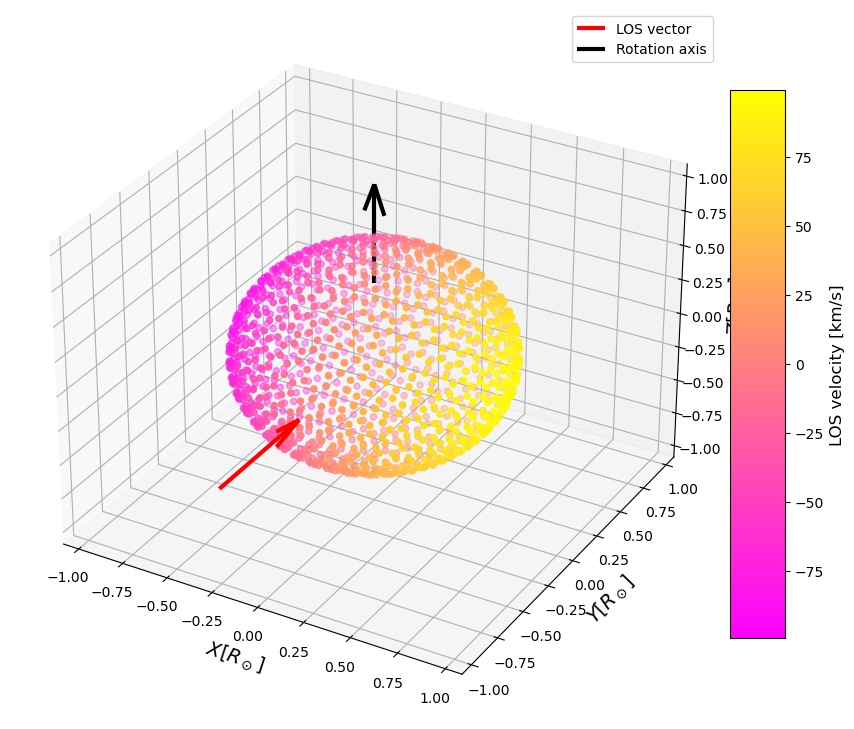

In [7]:
_, p, _ = plot_3D(mts[0], 'los_velocities', cmap='spring')

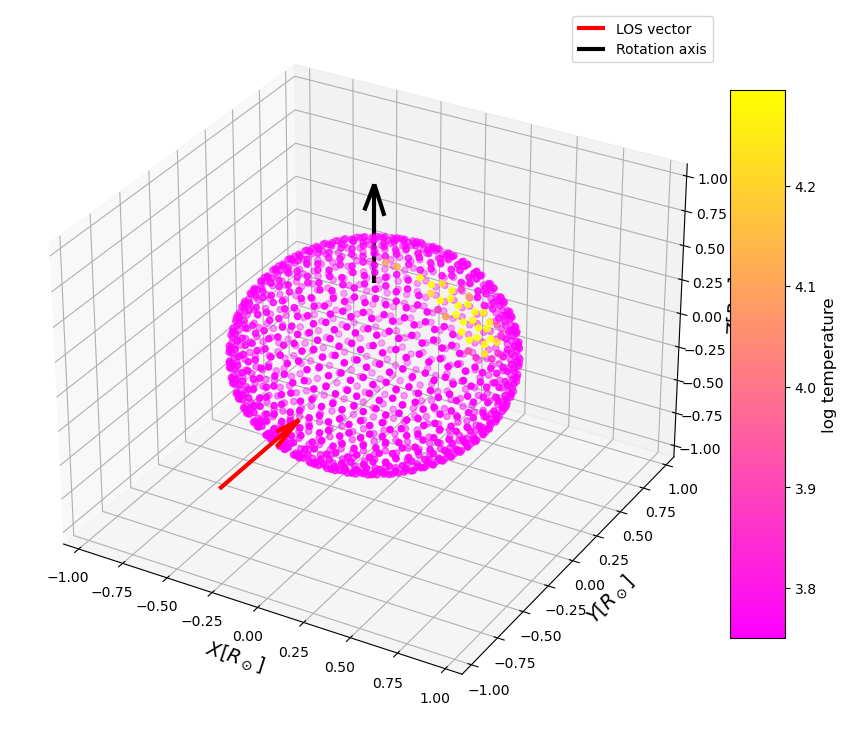

In [8]:
_, p, _ = plot_3D(mts[0], 0, cmap='spring', property_label='log temperature')

In [9]:
import matplotlib.pyplot as plt

vws = jnp.linspace(1000., 20000., 100)

(0.0, 10000000.0)

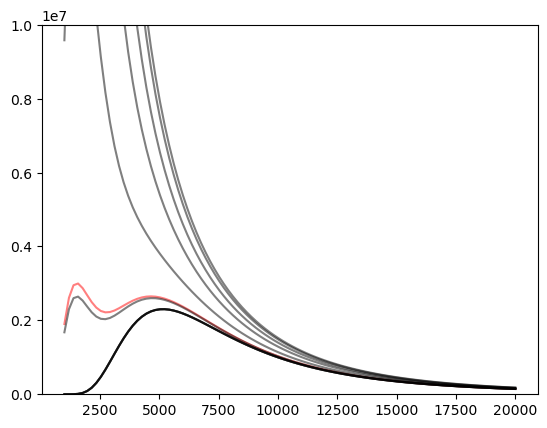

In [10]:
i = simulate_spectrum(blackbody_intensity, m, jnp.log10(vws))
plt.plot(vws, i[:, 0], color='red', alpha=0.5)

for _mt in mts:
    i = simulate_spectrum(blackbody_intensity, _mt, jnp.log10(vws), 16)
    plt.plot(vws, i[:, 1], color='black', alpha=0.5)

plt.gca().set_ylim(0, 1e7)

In [11]:
jnp.sum(i[:, 0])

Array(88048522.17841454, dtype=float64)